In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import DataLoader
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm import tqdm
from teenmag_dataset import TeenmagData
from faces_dataset import FacesData

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.version.cuda)

cuda
11.3


# Encoder Decoder

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, latent_dims, h, w):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, latent_dims)
        self.linear3 = nn.Linear(hidden_dims, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [4]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, latent_dims, h, w):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dims, hidden_dims, latent_dims,h ,w)
        self.decoder = Decoder(input_dims, hidden_dims, latent_dims, h, w)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
class Decoder(nn.Module):
    def __init__(self, input_dims, hidden_dims, latent_dims, h, w):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, input_dims)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, h, w))

# Datasets

In [12]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [13]:
batch_size = 8
data = torch.utils.data.DataLoader(
        #torchvision.datasets.MNIST('./data', 
        torchvision.datasets.FashionMNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=batch_size,
        shuffle=True)

# Hparams
input_dims = ds.h*ds.w
latent_dims = 2
hidden_dims = 2048
epochs = 2000
h, w = 28, 28

In [40]:
batch_size = 16
ds = FacesData(limit=45)
ds.process()

data = torch.utils.data.DataLoader(
        #TeenmagData(transform=torchvision.transforms.ToTensor()),
        ds,
        batch_size=batch_size,
        shuffle=True)
sample = next(iter(data))[0]

# Hparams
h, w = ds.h, ds.w
input_dims = ds.h*ds.w
latent_dims = 2
hidden_dims = 2048
epochs = 1000

Loading 45/4590 files.
 Images before cleaning: 45.
 Images after cleaning: 28, removed: 17
Processed into shape: torch.Size([28, 1, 64, 64])


In [8]:
print(sample.shape)

torch.Size([16, 1, 64, 64])


## Visualize

Feature batch shape: torch.Size([16, 1, 64, 64])
Labels batch shape: torch.Size([16])


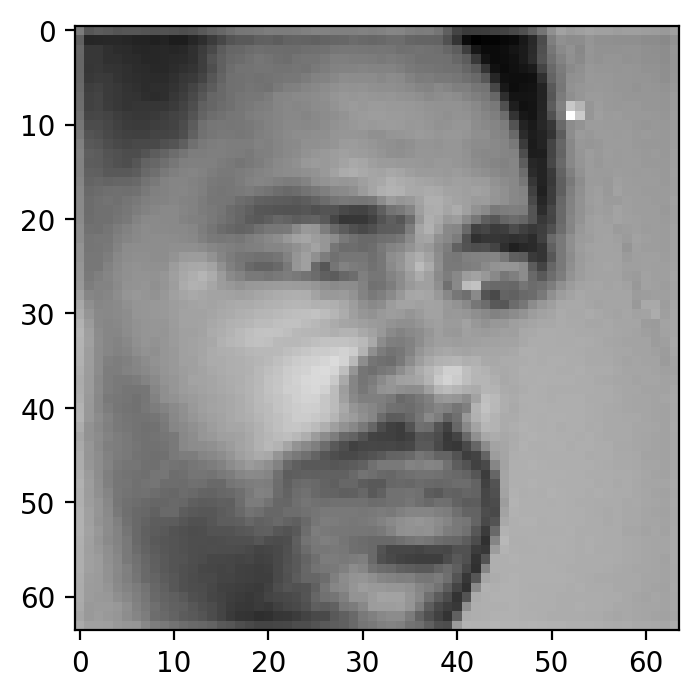

Label: 0


In [29]:
# Display image and label.
train_features, train_labels = next(iter(data))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:, :]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Train

In [41]:
print(f"(Training on {device}.")
vae = VariationalAutoencoder(input_dims, hidden_dims, latent_dims, h, w).to(device) # GPU
vae = train(vae, data, epochs)

(Training on cuda.


100%|██████████████████| 1000/1000 [00:12<00:00, 79.17it/s]


In [31]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w_ = w
    img = np.zeros((n*h, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(h, w).to('cpu').detach().numpy()
            #print(x_hat.shape)
            img[(n-1-i)*w_:(n-1-i+1)*w_, j*w_:(j+1)*w_] = x_hat

    plt.imshow(img, extent=[*r0, *r1], cmap='gray')

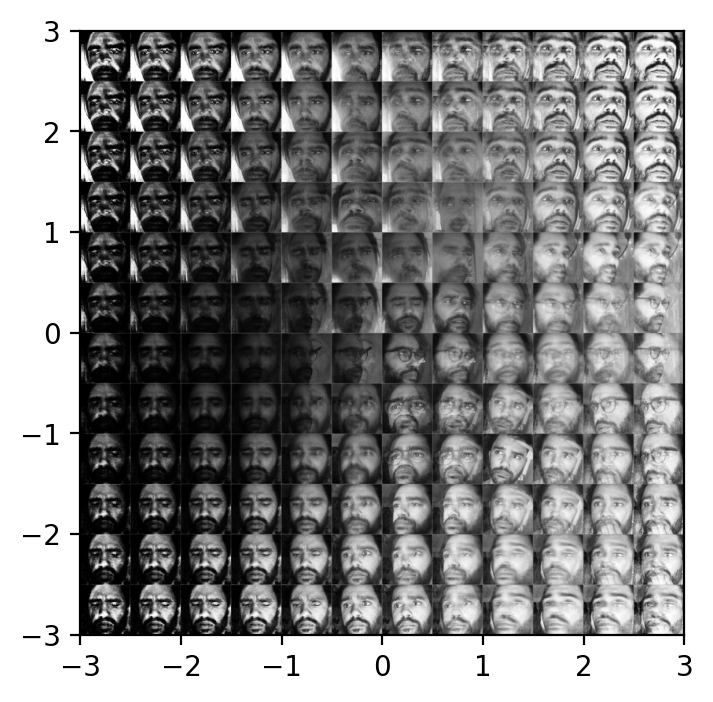

In [44]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

# Extra Fun

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

The following code produces a row of images showing the interpolation between digits.

In [63]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(h, w)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [90]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 0][1].to(device) # find a 1
x_2 = x[y == 0][-1].to(device) # find a 0

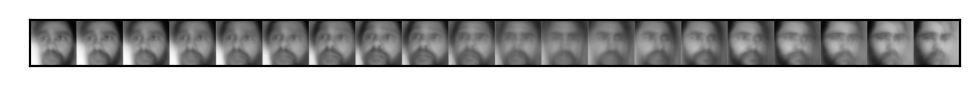

In [91]:
interpolate(vae, x_1, x_2, n=20)

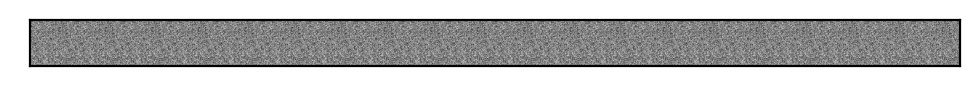

In [92]:
interpolate(autoencoder, x_1, x_2, n=20)

I also wanted to write some code to generate a GIF of the transition, instead of just a row of images. The code below modifies the code above to produce a GIF.

In [57]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=10):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)
    
    return images_list

In [58]:
imgs = interpolate_gif(vae, "vae", x_1, x_2)
img = Image.open('vae.gif').convert('RGB')
plt.imshow(img)
plt.show()

ValueError: cannot reshape array of size 4096 into shape (28,28)

<img src="vae.gif">

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)